# Training Notebook

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from NMPC_Net.dataset import dataset
from NMPC_Net.controller import utils
from NMPC_Net.controller.MPC import MPC, MPCParams
from NMPC_Net.simulation import simulation
from sklearn import preprocessing
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 10]

2022-04-25 11:46:32.118526: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-25 11:46:32.118550: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
X_raw,y = dataset.Dataset.load('data/data5-200000.csv')

In [ ]:
#scaler = preprocessing.StandardScaler().fit(X_raw)
#X = scaler.transform(X_raw)
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.20, random_state=42)

In [ ]:
normalizationLayer = tf.keras.layers.Normalization(axis=-1, input_dim=5)
normalizationLayer.adapt(X_train)

In [ ]:
batch_size, lr, num_epochs = 5000, 0.001, 800
loss = tf.keras.losses.MeanSquaredError()
trainer = tf.keras.optimizers.Adam(learning_rate=lr)

In [ ]:
net = tf.keras.models.Sequential([
    normalizationLayer,
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(2)
])
net.summary()

In [ ]:
net.compile(trainer, loss)
net.fit(
    x = X_train,
    y = y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
    use_multiprocessing=True)

In [ ]:
net.evaluate(x=X_test, y=y_test)

In [ ]:
net.save('model-temp.hdf5')

In [2]:
loaded_model = tf.keras.models.load_model('model-temp.hdf5')
def nnController(initialState, finalState):
    relativeInitial, relativeFinal = utils.absoluteToRelative(initialState, finalState)
    inputVector = tf.constant([
        relativeInitial[0],
        relativeFinal[0],
        relativeFinal[1],
        relativeFinal[2],
        relativeFinal[3]
    ], shape=(1,5))
    #normalizedInput = scaler.transform(inputVector)
    predictedControl = loaded_model.predict(inputVector)
    return np.array([predictedControl[0][0], predictedControl[0][1]], dtype=np.double)

2022-04-25 11:46:39.391773: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-25 11:46:39.391798: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-25 11:46:39.391814: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (desktop): /proc/driver/nvidia/version does not exist
2022-04-25 11:46:39.391988: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
ds = dataset.Dataset()
initialState = ds._get_rand_x0()
targetState = ds._get_rand_xf(initialState)

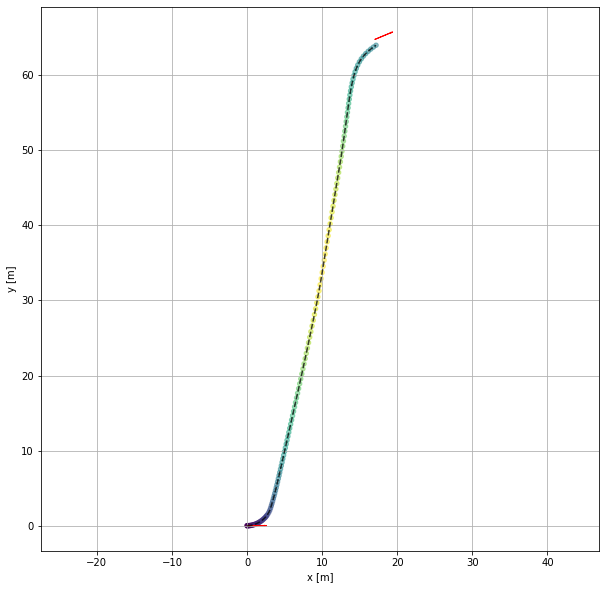

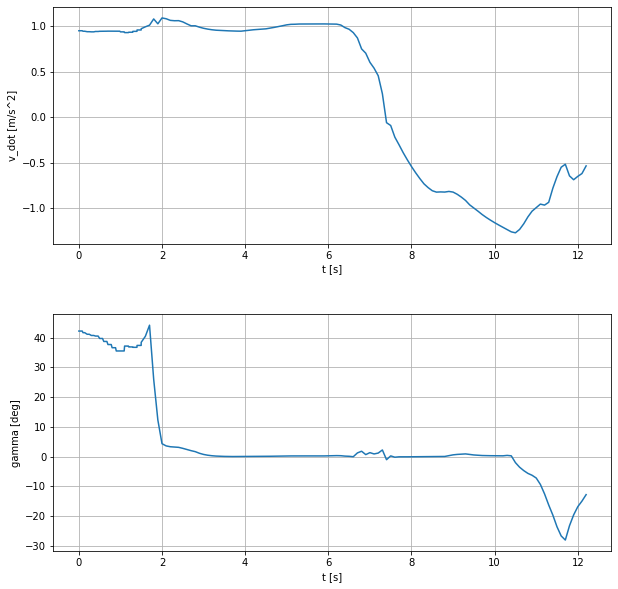

In [14]:
sim1 = simulation.Simulation(
    initialState,
    targetState,
    10.0,
    nnController,
    stop_r=1.0)

sim1.run_simulation(20.0, quiet=True)
simulation.plot_path(sim1)
simulation.plot_input(sim1)

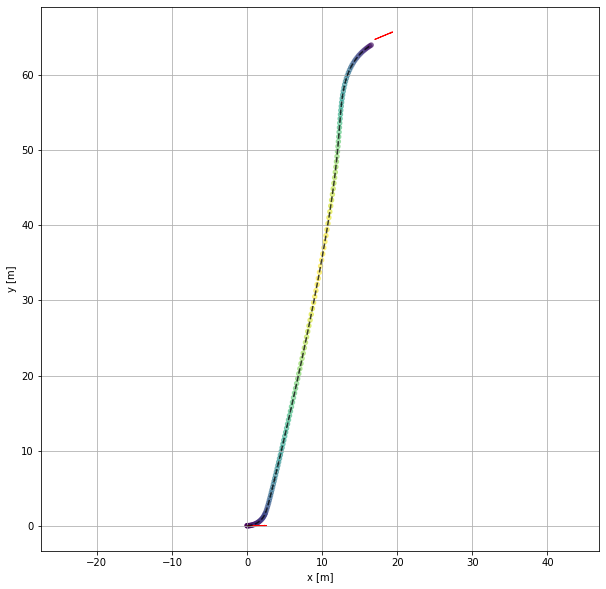

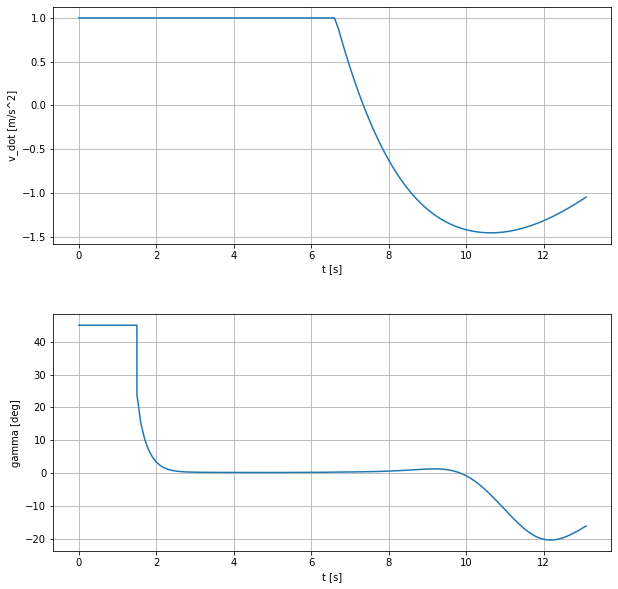

In [15]:
params = MPCParams()
params.H = 10 # seconds
mpcController = MPC(params=params)
sim2 = simulation.Simulation(
    initialState,
    targetState,
    10.0,
    mpcController,
    stop_r=1.0)
sim2.run_simulation(20.0)
simulation.plot_path(sim2)
simulation.plot_input(sim2)